# First steps into `mamonca`

Table of contents

- Calculation of Curie temperature
- Metadynamics for the free energy difference of ferro- and paramagnetic states
- Thermodynamic integration for the free energy difference of fictitious bcc and fcc phases.

In this example, we are going to use the structure class from `pyiron`, which allows you for easy analysis of the crystal neighborhood

In [1]:
from mamonca import MC
import numpy as np
import matplotlib.pylab as plt

In [2]:
from pyiron_atomistics.atomistics.structure.factory import StructureFactory

In [3]:
# Create bcc structure (which is the ground state of iron)
bcc = StructureFactory().bulk("Fe", cubic=True).repeat(10)

neigh = bcc.get_neighbors(num_neighbors=8)

In [4]:
J = 0.05 * neigh.get_shell_matrix()[0]

mc = MC(len(bcc))
mc.set_heisenberg_coeff(J)
# Use this command to turn on spin dynamics
# mc.switch_spin_dynamics()
m_lst = []
T_lst = np.arange(0, 1600, 100)
for T in T_lst:
    mc.run(temperature=T, number_of_iterations=10000)
    m_lst.append(mc.get_magnetization()[-1])

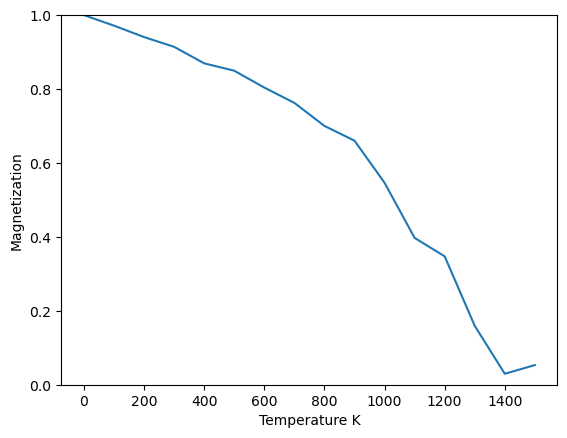

In [5]:
plt.xlabel("Temperature K")
plt.ylabel("Magnetization")
plt.ylim([0, 1])
plt.plot(T_lst, m_lst)

Here, as we chose the Heisenberg parameter randomly, the Curie temperature is somewhat higher than the experimental value of 1,043 K. In addition, since the system is relatively small, the total magnetization after the transition does not completely vanish. The residual magnetization values above the Curie temperature can therefore vary each time you run the simulation. The unit if the magnetization is given by the Heisenberg parameter. Here the calculation was done using Monte Carlo, but by setting `mc.switch_spin_dynamics()` you can also turn on spin dynamics (cf. code above). The results after convergence should be more or less the same.

## Thermodynamic integration

Let's now take a look at the energy difference of iron in the two most prominent phases: Face-Centered-Cubic (fcc) and Body-Centered-Cubic (bcc). The energy difference can be calculated using [Thermodynamic Integration](https://en.wikipedia.org/wiki/Thermodynamic_integration), where we vary the unitless $\lambda$ parameter (cf. [Wikipedia](https://en.wikipedia.org/wiki/Thermodynamic_integration#Derivation)) and integrate over the measured potential energies.

In [6]:
fcc = StructureFactory().bulk("Fe", crystalstructure="fcc", a=3.5, cubic=True).repeat(10)

# Let's make a fictitious bcc structure by applying a strain of -10% along z.
# This obviously does not create a real bcc structure, but it's good enough for our purpose to find the right neighbors
bcc = fcc.apply_strain([0, 0, -0.1], return_box=True)

neigh_fcc = fcc.get_neighbors()
neigh_bcc = bcc.get_neighbors(num_neighbors=8)

In [7]:
J_fcc = -0.1
J_bcc = 0.5

In [8]:
mc = MC(len(fcc))
mc.set_heisenberg_coeff(J_bcc * neigh_bcc.get_shell_matrix()[0])
mc.set_heisenberg_coeff(J_fcc * neigh_fcc.get_shell_matrix()[0], index=1)

In [9]:
ti_lambda = np.linspace(0, 1, 11)
temperature = 300

In [ ]:
E_lst = []
relaxation_steps = 5000
measurement_steps = 5000
for ll in ti_lambda:
    mc.set_lambda(ll)
    mc.run(temperature=temperature, number_of_iterations=relaxation_steps)
    mc.run(temperature=temperature, number_of_iterations=measurement_steps)
    E_lst.append(
        [mc.get_mean_energy(index=ii) for ii in [0, 1]]
    )

In [ ]:
E_diff = np.diff(E_lst, axis=-1).flatten() / len(fcc)
plt.xlabel("lambda")
plt.ylabel("E_bcc - E_fcc")
plt.plot(ti_lambda, E_diff);

In [ ]:
print("The free energy difference between bcc and fcc at 300 K is", E_diff.sum() * np.diff(ti_lambda).mean(), "eV")

## Metadynamics

[Metadynamics](https://en.wikipedia.org/wiki/Metadynamics) is a simulation method which allows for the free energy distribution along a collective variable defined by the user. In mamonca, you can use the total magnetization as the collective variable, meaning you can obtain the free energy distribution along the total magnetization. For this, you only need to call `set_metadynamics` before `run`, where you must also specify the maximum magnetization value. In order to obtain a reliable result, you should also test the robustness by varying `energy_increment` and `length_scale` (cf. [Wikipedia](https://en.wikipedia.org/wiki/Metadynamics#Algorithm), where `energy_increment` is called $\omega$ and `length_scale` is called $\sigma$)

In [ ]:
# Create bcc structure (which is the ground state of iron)
bcc = StructureFactory().bulk("Fe", cubic=True).repeat(10)

neigh = bcc.get_neighbors(num_neighbors=8)

In [ ]:
J = 0.05 * neigh.get_shell_matrix()[0]

mc = MC(len(bcc))
mc.set_heisenberg_coeff(J)
temperature = 1000
mc.set_metadynamics(max_range=1)
mc.run(temperature=temperature, number_of_iterations=100000)

meta = mc.get_metadynamics_free_energy()

In [ ]:
plt.xlabel("Magnetization")
plt.ylabel("Free energy eV")
plt.plot(meta["magnetization"], meta["free_energy"])

The free energy minimum shows the most stable state. In this case it is around 0.5. Metadynamics, however, often requires a meticulous sampling, meaning with the standard energy increment of 0.001, you might overshoot and miss the global minimum. For a real measurement, it is recommended to make it as small as possible, meaning you should estimate the amount of time needed to run your calculation with Metadynamics with a small energy increment value and see what would be an acceptable total computation time.